<div class="alert alert-block alert-success">
<a id="ARIMA"></a>
    
# **Machine Learning in Action- Credit Card Fraud Detection**
9)  

    
</div>    

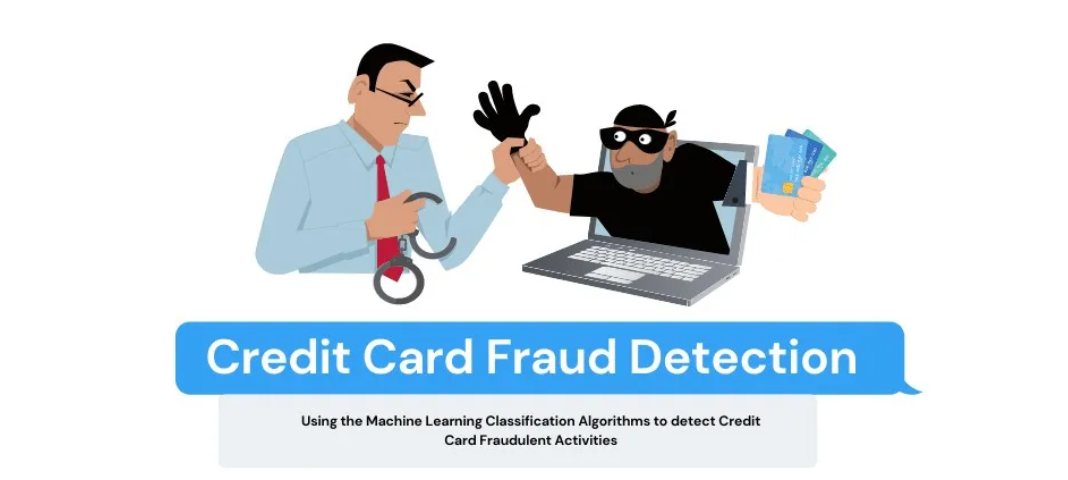

<div class="alert alert-block alert-warning">
<a id="Discussion"></a>


### Business Question
 **How can we detect fraudulent credit card transactions efficiently and reduce financial losses for the company?-**   


###  Statistical Questions 
✔ ** How to handle a highly **class imbalanced** dataset- where fraud cases will be a small proportion of the data set.   
✔ ** What are the best technoqies amd metrics for  **class imbalanced** datasets.
✔ ** What are the most imporant features in users to raise an alarm for credit card fraud cases. **

<div>


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
credit_card_data = pd.read_csv('card_transdata.csv')

<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    

## Exploratory Data Analysis & Data Cleaning 


</div>

Here we perform an initial exploration of the dataset including feature data types, label distribution, and feature correlations. This process will indicate what, if any, transformations need to be done to the dataset before fitting a model with it.

In [17]:
credit_card_data.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


In [19]:
credit_card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


## Dropping Duplicates ##

In [21]:
#check for and drop possible duplicates
credit_card_dedup = credit_card_data.copy()

credit_card_dedup.drop_duplicates(inplace=True)

print(credit_card_dedup.shape)

(1000000, 8)


In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Define the scaled numerical features for outlier detection
numeric_features = ['distance_from_home_scaled', 'distance_from_last_transaction_scaled', 'ratio_to_median_purchase_price_scaled']

# Z-Score Method for Outlier Detection
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(zscore(data))
    return (z_scores > threshold).sum()

# IQR Method for Outlier Detection
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound)).sum()

# Apply outlier detection methods
outliers_zscore = credit_card_dedup[numeric_features].apply(detect_outliers_zscore)
outliers_iqr = credit_card_dedup[numeric_features].apply(detect_outliers_iqr)

# Print Outlier Summary
print("\nOutliers detected using Z-score:")
print(outliers_zscore)

print("\nOutliers detected using IQR:")
print(outliers_iqr)

# Visualizing Outliers using Boxplots
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=credit_card_dedup[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

KeyError: "None of [Index(['distance_from_home_scaled', 'distance_from_last_transaction_scaled',\n       'ratio_to_median_purchase_price_scaled'],\n      dtype='object')] are in the [columns]"

##  Results and Analysis ##

## Outliers Detected Using Z-score
The Z-score method identifies outliers as values that are more than **3 standard deviations** away from the mean.

| Feature | Outliers Detected |
|---------|------------------|
| **distance_from_home** | 13,324 |
| **distance_from_last_transaction** | 7,099 |
| **ratio_to_median_purchase_price** | 17,061 |

### Interpretation:
- **Fewer outliers detected compared to IQR** because Z-score assumes a **normal distribution** and tolerates more variation.
- The **'ratio_to_median_purchase_price'** feature has the **most outliers**, suggesting it is a key indicator of abnormal spending behavior.

---

## Outliers Detected Using IQR (Interquartile Range)
The IQR method classifies outliers as values that fall **beyond 1.5 times the interquartile range (Q1 and Q3).**

| Feature | Outliers Detected |
|---------|------------------|
| **distance_from_home** | 103,631 |
| **distance_from_last_transaction** | 124,367 |
| **ratio_to_median_purchase_price** | 84,386 |

###  Interpretation:
- **Much higher number of outliers detected compared to Z-score**, indicating the data **is not normally distributed** and may have **long tails or skewness**.
- The **'distance_from_last_transaction'** feature has the highest number of outliers, suggesting that transactions far from the last known location are uncommon but could be potential fraud cases.

---

##  Key Insights
✔ **A significant number of extreme values exist in the dataset**, particularly for transaction distance and price ratio.  
✔ **IQR detects more outliers than Z-score**, implying that the data might be **skewed** rather than following a perfect normal distribution.  
✔ **Fraudulent transactions could be hiding within these extreme values**, as unusual distances and price ratios often indicate suspicious activity.  

---


<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    

## Data Imbalance Check  


</div>

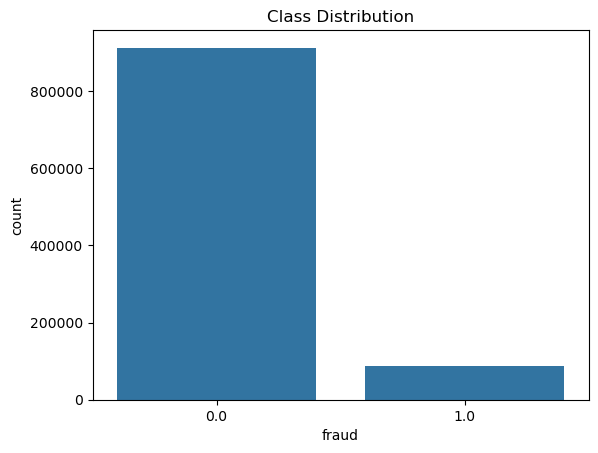

In [27]:
#plot label distribution as a piechart
sns.countplot(x='fraud', data=credit_card_dedup)
plt.title('Class Distribution')
plt.show()

Looking at the outputs from .head() and .info(), we can gather that:


*   The dataset is very clean and there is no data contained in the dataset that can be associated with a specific individual, limiting chance for bias.

*   All dataset features are numerical already, so we do not need to do feature transformations in order to train models.

*   There are no null values in the dataset.


The countplot of class labels shows that the dataset is very imbalanced with most data examples belonging to the 0 (not fraud) class. We will have to implement sampling methods before training a model to ensure proper representation of each class.


Below, we will take a look at the value distribution of the non-boolean value features and consider if scaling is needed.


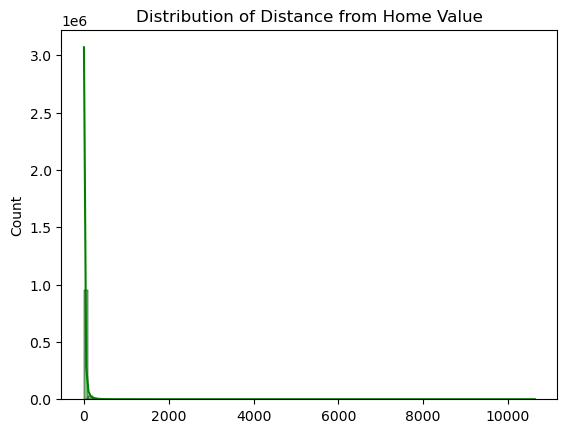

In [155]:
#plot the value distribution of the "distance_from_home" feature
sns.histplot(credit_card_dedup['distance_from_home'].values, bins=100, kde=True, color='g')
plt.title('Distribution of Distance from Home Value')
plt.show()



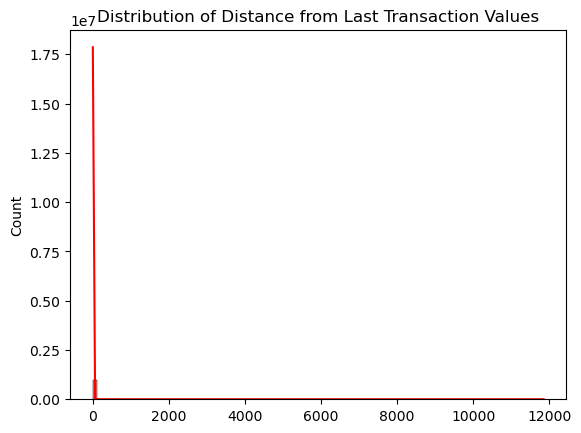

In [29]:
sns.histplot(credit_card_dedup['distance_from_last_transaction'].values, bins=100, kde=True, color='r')
plt.title('Distribution of Distance from Last Transaction Values')
plt.show()

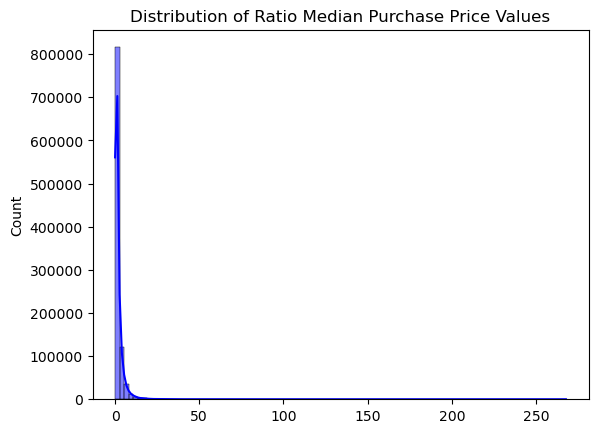

In [156]:
#plot the value distribution of the "time" feature
sns.histplot(credit_card_dedup['ratio_to_median_purchase_price'].values, bins=100, kde=True, color='b')
plt.title('Distribution of Ratio Median Purchase Price Values')
plt.show()

The ratio of median purchase values distribution shows the overwhelming majority of transactions are quite small. This makes sense since most people use credit cards for every day small purchases, and very rarely make large purchases.

The green and red charts corresponding to distance metrics show that most transactions occur near the account holder's home, and also in close proximity of each other. This is also logical since people would be buying things normally in the city where they live. 

In order to keep values smaller, we can apply the standard scaler to these features.


In [157]:
std_scaler = StandardScaler()

# Scale the Amount and Time columns
scaled_features = std_scaler.fit_transform(credit_card_dedup[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])

# Insert the scaled features at the beginning of the DataFrame
credit_card_dedup.insert(0, 'distance_from_home_scaled', scaled_features[:, 0])
credit_card_dedup.insert(1, 'distance_from_last_transaction_scaled', scaled_features[:, 1])
credit_card_dedup.insert(2, 'ratio_to_median_purchase_price_scaled', scaled_features[:, 2])

# Drop the original unscaled columns
credit_card_dedup.drop(columns=['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'], inplace=True)

In [160]:
credit_card_dedup.head(10)

,distance_from_home_scaled,distance_from_last_transaction_scaled,ratio_to_median_purchase_price_scaled,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.477882,-0.182849,0.043491,1.0,1.0,0.0,0.0,0.0
1,-0.241607,-0.188094,-0.189300,1.0,0.0,0.0,0.0,0.0
2,-0.329369,-0.163733,-0.498812,1.0,0.0,0.0,1.0,0.0
3,-0.372854,0.021806,-0.522048,1.0,1.0,0.0,1.0,0.0
4,0.268572,-0.172968,0.142373,1.0,1.0,0.0,1.0,0.0
5,-0.321795,0.318250,-0.628455,1.0,0.0,0.0,0.0,0.0
6,-0.350275,-0.157864,-0.552123,1.0,0.0,0.0,1.0,0.0
7,-0.333083,-0.182478,-0.196862,1.0,0.0,1.0,0.0,0.0
8,-0.393820,-0.098011,-0.109724,0.0,0.0,0.0,0.0,0.0
9,-0.272053,-0.079944,0.191993,1.0,0.0,0.0,1.0,0.0


By calculating the correlation matrix of the data, we can see if there are any highly correlated (and therefore less unique) features. Using the .corr() funnction of a pandas dataframe allows us to quickly and easily generate the correlation matrix.

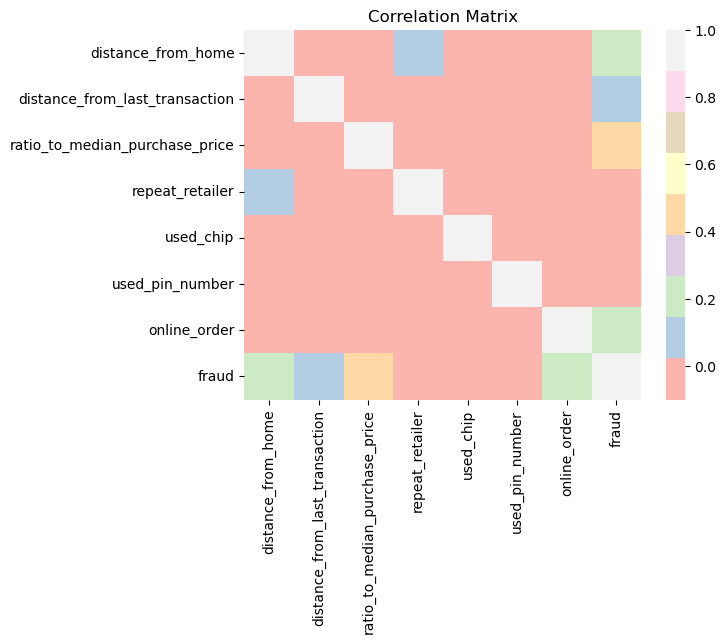

In [25]:
#plot the correlation between features to ensure they are all unique
corr_matrix = credit_card_dedup.corr().round(1)
sns.heatmap(corr_matrix, annot=False, cmap='Pastel1')
plt.title('Correlation Matrix')
plt.show()

We can see a clear diagonal line without grouping, which tells us that these features are all unique and important. We do not need to drop features.

We can also see a notably higher correlation between median purchase price and fraud. This could be an important connection.

<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    

## Comparing Sampling Strategies


</div>


Two strategies to consider are random upsampling, and downsampling.
### See Appendix A for both Strategies ###


*   Upsampling involves generating synthetic data points to fill out the underrepresented class. For our case, this will ensure *Count(Class 0) = Count(Class 1 + Synthetic Data)*
*   Downsampling involves randomly sampling an amount of examples from the majority class that equals the amount of examples in the minority class. This will ensure *Count(RandSamp(Class 0)) = Count(Class 1)*


Both strategies have their own strengths and weaknesses, as outlined in this Medium Article: https://medium.com/@rithpansanga/choosing-the-right-size-a-look-at-the-differences-between-upsampling-and-downsampling-methods-daae83915c19

We will consider upsampling using SMOTE (Synthetic Minority Over-Sampling Technique) due to the fact that there are so few fraud examples in the dataset. If we downsample, we may not have enough data to work with.

Sampling strategies should be applied during cross validation so we do not tamper with the validation sets before they are used.


In [51]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #commonly used tool for upsampling

#split the data into features and labels
X = credit_card_dedup.drop(columns=['fraud'], inplace = False)
y = credit_card_dedup['fraud']

#split into train and test set. Add stratification to ensure same class ratio for both train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53, stratify=y)



In [53]:
#print out the percentage of each class in the training dataset
print(y_train.value_counts(normalize=True))

fraud
0.0    0.912597
1.0    0.087403
Name: proportion, dtype: float64


<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    

## Baseline: Before Upsampling 91.25%


</div>

As we can see from above, only 8.7% of the training dataset represents fraud examples. For a train split of 70%, this ~8.7% represents around 61000 fraud cases, with the other ~639000 representing non-fraud cases. Since we apply SMOTE during cross validation with 5 folds, we will apply upsampling on 4*(639000/5) = ~511200 samples on average for the 4 splits relegated to training with 1 hold out split.

<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    

## Model and Hyperparameter Selection


</div>



Credit card fraud detection is a relatively well-studied problem in academia. We have searched for some academic papers and articles to determine which models are commonly implemented for this task, so we can compare their performances. We have listed the sources we used here.

Academic Sources:

1.   For using Random Forest Classifier: https://www.sciencedirect.com/science/article/pii/S2772662223000036#:~:text=The%20machine%20learning%20models%20of,favour%20the%20majority%20class%20solely.
2.   Considerations for other model types (Logistic Regression, KNN): https://medium.com/@rashmilis1/credit-card-fraud-detection-a-data-science-project-3f6510d36e54


We will perform randomized search with cross validation for hyperparameter search for each model type.


<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    

## Stratified K-Fold CV (Cross-Validation)


</div>

Stratification is used because the dataset contains unbalanced classes. Therefore if we cross-validate with a normal technique it may produce subsamples that have a varying distribution of classes. Some unbalanced samples may produce exceptionally high scores leading to a high cross-validation score overall, which is undesirable. Therefore we create stratified subsamples that preserve the class frequencies in the individual folds to ensure that we are able to get a clear picture of the model performance.


## Hyperparameter Tuning Using Randomized Search with Stratified K-Fold Cross-Validation ##

In [55]:
from re import search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score

#model parameters to try
logistic_regression_param = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
random_forest_param = {"n_estimators": [50, 100], "max_depth": [3, 5, 10]}
knn_param = {"n_neighbors": [3, 5, 10], "weights": ["uniform", "distance"]}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=False)

#define randomized search cross validations

log_reg_search = RandomizedSearchCV(LogisticRegression(), logistic_regression_param, n_iter=5)
rf_search = RandomizedSearchCV(RandomForestClassifier(), random_forest_param, n_jobs=-1, verbose = 4, n_iter=5)
knn_search = RandomizedSearchCV(KNeighborsClassifier(), knn_param, n_jobs=-1, verbose = 4, n_iter=5)




<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    

## SMOTE (Synthetic Minority Oversampling Technique)


</div>

SMOTE (Synthetic Minority Oversampling Technique) synthesize elements for the minority class. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line

In [57]:
def smote_cv_search(searcher, X_train, y_train):
  #iterate through searchers and train validation splits. Apply SMOTE to each split in turn

  #init score lists
  accuracy_scores = []
  precision_scores = []
  recall_scores = []
  f1_scores = []

  #temp var for saving best estimator within the KFold loop
  current_best_model = None

  for train, validation in stratified_kfold.split(X_train, y_train):
    #build pipeline for SMOTE
    pipeline = make_pipeline(SMOTE(random_state=53), searcher)

    #SMOTE is applied to the train splits
    pipeline.fit(X_train.iloc[train], y_train.iloc[train])

    #SMOTE is not applied to the validation split. Get predictions for scoring from best estimator model
    predictions = searcher.best_estimator_.predict(X_train.iloc[validation])

    #add the best estimator for this model type to the best models list
    current_best_model = searcher.best_estimator_

    #calculate metrics
    accuracy_scores.append(pipeline.score(X_train.iloc[validation], y_train.iloc[validation]))
    precision_scores.append(precision_score(y_train.iloc[validation], predictions))
    recall_scores.append(recall_score(y_train.iloc[validation], predictions))
    f1_scores.append(f1_score(y_train.iloc[validation], predictions))

  #print out the mean metrics scores for this model type
  print("Mean Accuracy Score: " + str(np.mean(accuracy_scores)))
  print("Mean Precision Score: " + str(np.mean(precision_scores)))
  print("Mean Recall Score: " + str(np.mean(recall_scores)))
  print("Mean F1 Score: " + str(np.mean(f1_scores)))
  print("\n")

  return current_best_model


In [59]:
from sklearn.metrics import classification_report, confusion_matrix

#labels for classification report
labels = ["Not Fraud", "Fraud"]

In [61]:
#fit best Logistic Regression model
best_log_reg = smote_cv_search(log_reg_search, X_train, y_train)

#print out best model parameters
print("Best Logistic Regression Model Parameters: " + str(best_log_reg.get_params()))

Mean Accuracy Score: 0.9337028571428572
Mean Precision Score: 0.5728733535951468
Mean Recall Score: 0.9492661471836215
Mean F1 Score: 0.714530311161686


Best Logistic Regression Model Parameters: {'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [29]:
#make predictions on the original test set with the best Logistic Regression Model
log_reg_predictions = best_log_reg.predict(X_test)
print(classification_report(y_test, log_reg_predictions, target_names = labels))

              precision    recall  f1-score   support

   Not Fraud       0.99      0.93      0.96    273779
       Fraud       0.58      0.95      0.72     26221

    accuracy                           0.93    300000
   macro avg       0.79      0.94      0.84    300000
weighted avg       0.96      0.93      0.94    300000



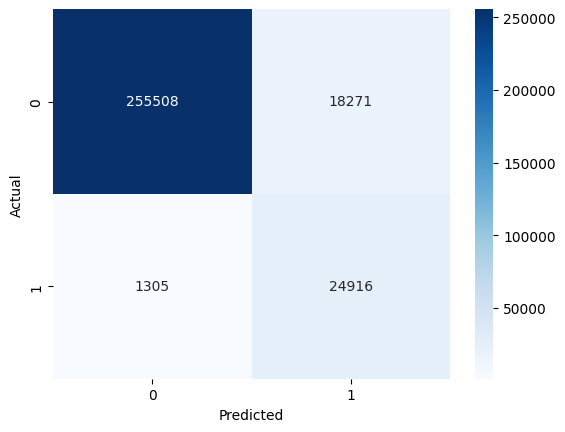

In [30]:
#print out the confusion matrix for Logistic Regression model using seaborn
cm = confusion_matrix(y_test, log_reg_predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/var/folders/gz/r077fvjj6fj0kjcr385stq1r0000gn/T/ipykernel_85589/464314073.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


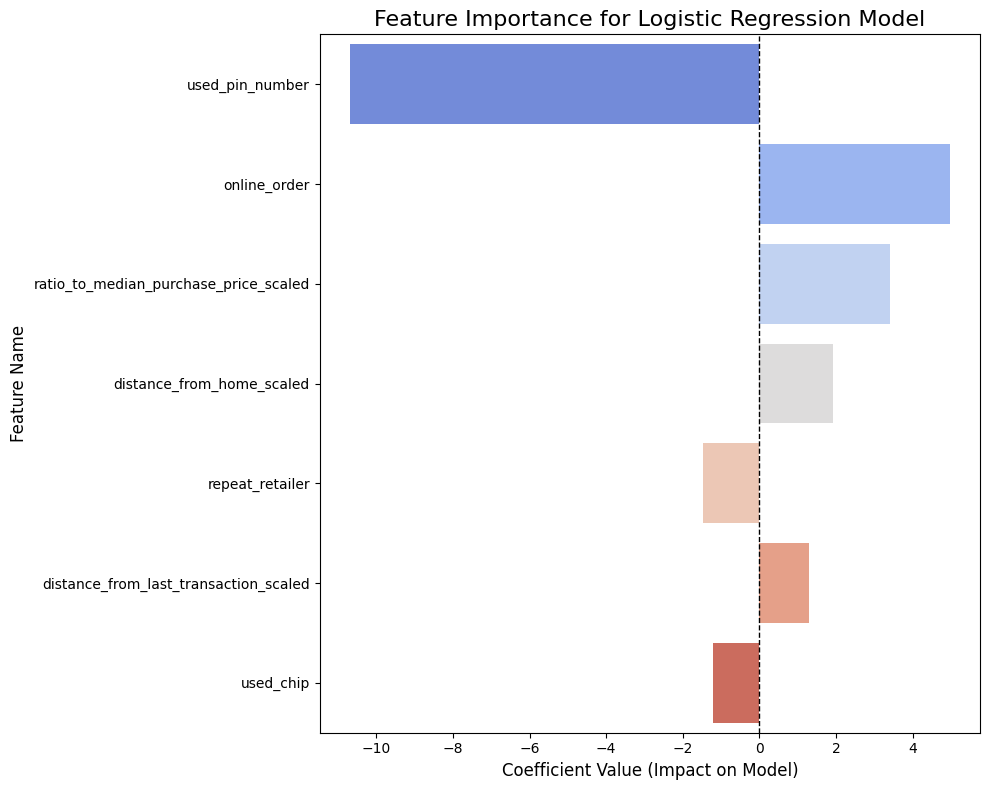

In [31]:
# Prepare feature importance data
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_log_reg.coef_[0]
})

# Sort features by absolute importance for better interpretability
feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance,
    palette='coolwarm'
)
plt.title('Feature Importance for Logistic Regression Model', fontsize=16)
plt.xlabel('Coefficient Value (Impact on Model)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Add a vertical line at 0 for better context
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


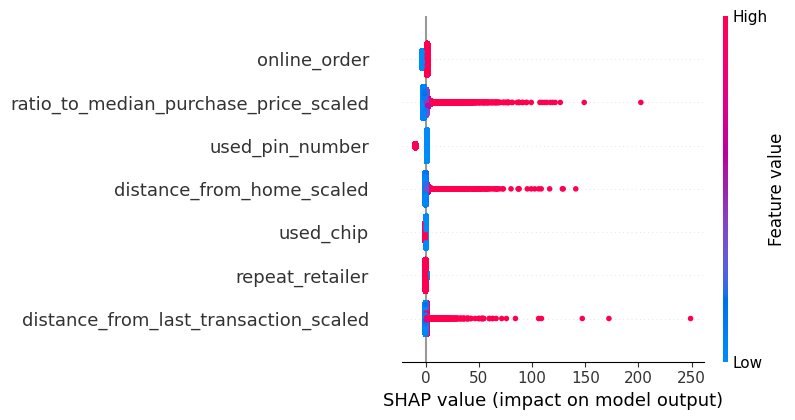

In [32]:
import shap

# Get SHAP values for the best logistic regression model
explainer = shap.Explainer(best_log_reg, X_train)  # Use the best model and the training data
shap_values = explainer(X_test)  # Get SHAP values for the test set

# Plot a SHAP summary plot to visualize feature importance across all samples
shap.summary_plot(shap_values, X_test)



In [33]:
#fit best Random Forest model
best_rf = smote_cv_search(rf_search, X_train, y_train)

#print out best model parameters
print("Best Random Forest Model Parameters: " + str(best_rf.get_params()))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......max_depth=3, n_estimators=50;, score=0.997 total time=  20.0s
[CV 2/5] END ......max_depth=3, n_estimators=50;, score=0.987 total time=  20.2s
[CV 4/5] END ......max_depth=3, n_estimators=50;, score=0.973 total time=  20.3s
[CV 5/5] END ......max_depth=3, n_estimators=50;, score=0.976 total time=  20.5s
[CV 3/5] END ......max_depth=3, n_estimators=50;, score=0.974 total time=  21.2s
[CV 1/5] END .....max_depth=10, n_estimators=50;, score=1.000 total time=  39.0s
[CV 5/5] END .....max_depth=10, n_estimators=50;, score=1.000 total time=  42.3s
[CV 4/5] END .....max_depth=10, n_estimators=50;, score=1.000 total time=  42.3s
[CV 3/5] END .....max_depth=10, n_estimators=50;, score=1.000 total time=  42.5s
[CV 2/5] END .....max_depth=10, n_estimators=50;, score=1.000 total time=  44.0s
[CV 1/5] END .....max_depth=5, n_estimators=100;, score=0.999 total time=  59.9s
[CV 2/5] END .....max_depth=5, n_estimators=100;,

In [34]:
#make predictions with the best Random Forest model
rf_predictions = best_rf.predict(X_test)
print(classification_report(y_test, rf_predictions, target_names = labels))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    273779
       Fraud       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



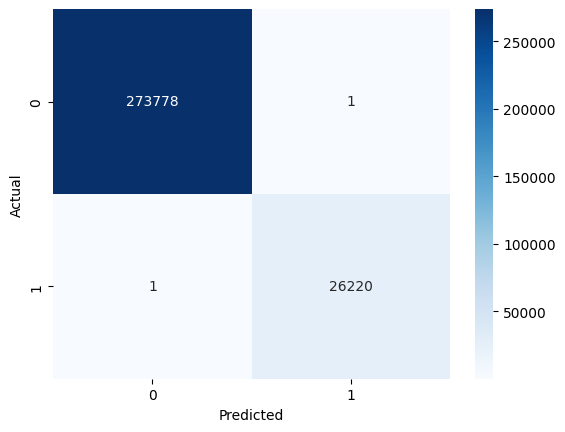

In [35]:
cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import numpy as np

# Assuming these are already defined:
# best_rf_model: trained Random Forest model
# X_test, y_test: test dataset

# Predict probabilities for the positive class (Fraud)
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for SMOTE Sampled Random Forest Model')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

NameError: name 'best_rf_model' is not defined

<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    

## Feature Importance- Random Forest Model 


</div>

/var/folders/gz/r077fvjj6fj0kjcr385stq1r0000gn/T/ipykernel_85589/1846086110.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


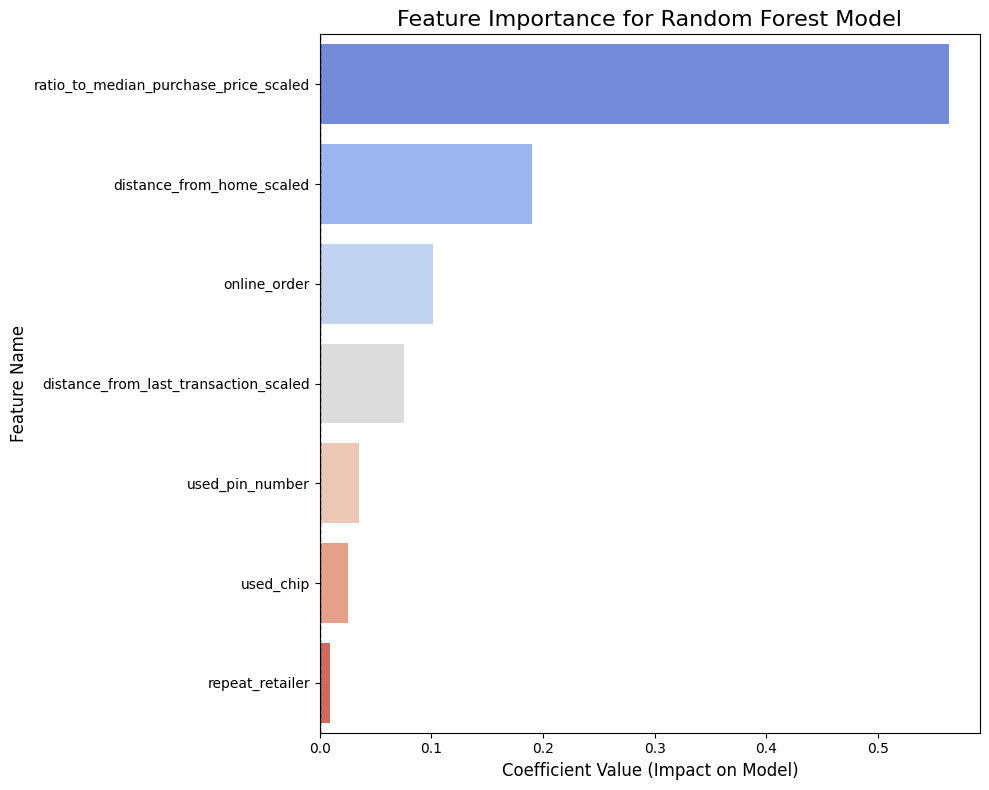

In [36]:
# Prepare feature importance data
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
})

# Sort features by absolute importance for better interpretability
feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance,
    palette='coolwarm'
)
plt.title('Feature Importance for Random Forest Model', fontsize=16)
plt.xlabel('Coefficient Value (Impact on Model)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Add a vertical line at 0 for better context
plt.tight_layout()
plt.show()

### Top Features for Credit Card Fraud Detection

> ⚠️ <span style="color:blue;">**Check Appendix for possible use case of this feature for Client**</span>*
1. **Unusual Purchase Amount (vs. Usual Spending)**  
   - Fraudsters often spend unusually large or small amounts.  

2. **Distance from Home**  
   - Fraudsters may transact far from the user's usual location.  

3. **Online Orders**  
   - Online transactions are riskier without physical verification.  

4. **Distance from Last Transaction**  
   - Rapid transactions across distant locations are unlikely.  

5. **PIN Usage**  
   - Transactions without a PIN are riskier.  

6. **Chip Usage**  
   - Chip transactions are more secure.  

7. **Familiar Retailer**  
   - New or unusual retailers can signal fraud.  


In [38]:
#fit best KNN model
best_knn = smote_cv_search(knn_search, X_train, y_train)

#print out best model parameters
print("Best KNN Model Parameters: " + str(best_knn.get_params()))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.999 total time=  22.0s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.999 total time=  22.5s
[CV 4/5] END ...n_neighbors=5, weights=distance;, score=0.999 total time=  24.0s
[CV 1/5] END ...n_neighbors=5, weights=distance;, score=0.999 total time=  24.1s
[CV 2/5] END ...n_neighbors=5, weights=distance;, score=0.999 total time=  24.1s
[CV 5/5] END ...n_neighbors=5, weights=distance;, score=0.999 total time=  24.4s
[CV 3/5] END ...n_neighbors=5, weights=distance;, score=0.999 total time=  24.6s
[CV 1/5] END ...n_neighbors=10, weights=uniform;, score=0.998 total time=  29.5s
[CV 4/5] END ...n_neighbors=10, weights=uniform;, score=0.998 total time=  29.6s
[CV 5/5] END ...n_neighbors=10, weights=uniform;, score=0.998 total time=  29.7s
[CV 2/5] END ...n_neighbors=10, weights=uniform;, score=0.998 total time=  30.0s
[CV 3/5] END ...n_neighbors=10, weights=uniform;,

In [39]:
#make predictions with the best Random Forest model
knn_predictions = best_knn.predict(X_test)
print(classification_report(y_test, knn_predictions, target_names = labels))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    273779
       Fraud       0.98      1.00      0.99     26221

    accuracy                           1.00    300000
   macro avg       0.99      1.00      0.99    300000
weighted avg       1.00      1.00      1.00    300000



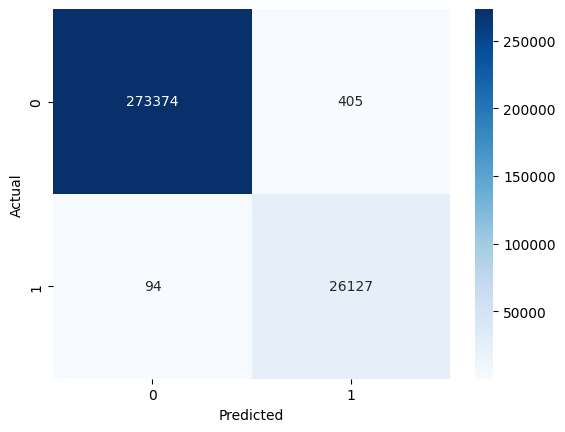

In [40]:
cm = confusion_matrix(y_test, knn_predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Comparing Random Forest model with upsampling to Random Forest with no upsampling

In [22]:
rf_search_no_upsample = RandomizedSearchCV(RandomForestClassifier(), random_forest_param, n_jobs=-1, verbose = 4, cv=stratified_kfold, n_iter=5)

rf_search_no_upsample.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 2/5] END ......max_depth=3, n_estimators=50;, score=0.973 total time=  13.8s
[CV 1/5] END ......max_depth=3, n_estimators=50;, score=0.953 total time=  13.9s
[CV 5/5] END ......max_depth=3, n_estimators=50;, score=0.941 total time=  13.9s
[CV 4/5] END ......max_depth=3, n_estimators=50;, score=0.917 total time=  14.0s
[CV 3/5] END ......max_depth=3, n_estimators=50;, score=0.973 total time=  15.4s
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.995 total time=  20.9s
[CV 2/5] END ......max_depth=5, n_estimators=50;, score=0.997 total time=  21.1s
[CV 4/5] END ......max_depth=5, n_estimators=50;, score=0.999 total time=  19.7s
[CV 3/5] END ......max_depth=5, n_estimators=50;, score=1.000 total time=  20.6s
[CV 5/5] END ......max_depth=5, n_estimators=50;, score=0.999 total time=  21.0s
[CV 2/5] END ....max_depth=10, n_estimators=100;, score=1.000 total time=  51.9s
[CV 3/5] END ....max_depth=10, n_estimators=100;,

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10],
                                        'n_estimators': [50, 100]},
                   verbose=4)

In [23]:
best_rf_no_upsample = rf_search_no_upsample.best_estimator_

no_upsample_preds = best_rf_no_upsample.predict(X_test)

print(classification_report(y_test, no_upsample_preds, target_names = labels))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    273779
       Fraud       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



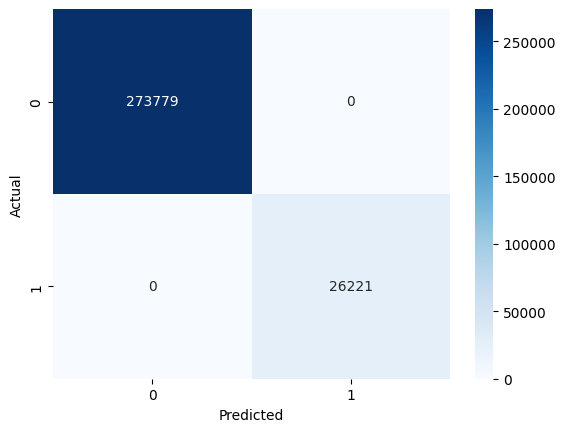

In [24]:
cm = confusion_matrix(y_test, no_upsample_preds)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In this project, we used a Random Forest classifier for detecting fraudulent transactions. Random Forest was chosen because it provided the best forecasting results compared to Logistic Regression and K-Nearest Neighbors (KNN). Below is an explanation of why Random Forest outperformed the other models and why upsampling did not significantly change the results.


---

#### Why Random Forest Outperformed Logistic Regression and KNN
1. **Robustness to Nonlinearity:**  
   - Random Forest is an ensemble method that creates multiple decision trees and averages their results. This makes it capable of capturing complex, non-linear relationships in the data, which Logistic Regression cannot handle effectively due to its linear nature.

2. **Resistance to Overfitting:**  
   - By averaging multiple decision trees, Random Forest reduces overfitting compared to KNN, which is highly sensitive to noise in the data.

3. **Feature Importance:**  
   - Random Forest inherently provides feature importance scores, enabling better understanding and interpretability of the factors influencing the predictions, which Logistic Regression and KNN do not offer as naturally.

---

#### Why Upsampling Did Not Change Random Forest Results
1. **Bootstrapping in Random Forest:**  
   - Random Forest uses bootstrapping to create multiple subsets of the data for training each tree. This naturally ensures that minority class samples (fraudulent transactions) are included in multiple trees, even without explicit upsampling.

2. **Class Weights in Random Forest:**  
   - Random Forest assigns implicit weights to the classes during training, based on their frequencies. This means the model already compensates for the imbalance between normal and fraudulent transactions without requiring explicit balancing.

3. **Overfitting Resistance:**  
   - Random Forest is robust to overfitting, even when the data contains duplicated or synthetic examples created through upsampling. As a result, the model performance is not significantly affected by upsampling.


<div class="alert alert-block alert-danger">
<a id="AppendixA"></a>

# Appendix A:
# Trying Random Upsampling

</div>

Random Oversampling: Randomly duplicate examples in the minority class.
The random oversampling may increase the likelihood of occurring overfitting, since it makes exact copies of the minority class examples. Let's say every data point from the minority class is copied 6 times before making the splits. If we did a 3-fold validation, each fold has (on average) 2 copies of each point! In this way a classifier might construct rules that are apparently accurate, but actually cover one replicated example.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

def random_upsample(X, y):
    """
    Randomly duplicates the minority class (fraud cases) to balance class distribution.
    """
    df = X.copy()
    df['fraud'] = y  # Add the target column back

    # Separate majority (non-fraud) and minority (fraud) classes
    majority = df[df['fraud'] == 0]
    minority = df[df['fraud'] == 1]

    # Upsample the minority class by duplicating existing fraud cases
    minority_upsampled = resample(minority, 
                                  replace=True,  # Sample with replacement
                                  n_samples=len(majority),  # Match majority class size
                                  random_state=42)

    # Combine the upsampled minority class with the majority class
    balanced_df = pd.concat([majority, minority_upsampled])

    # Shuffle the dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate back into features and labels
    return balanced_df.drop(columns=['fraud']), balanced_df['fraud']

def cross_val_with_random_upsampling(searcher, X_train, y_train, stratified_kfold):
    """
    Applies Random Upsampling within Stratified K-Fold Cross-Validation while tuning hyperparameters.
    """
    # Initialize score lists
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    current_best_model = None

    for train_idx, val_idx in stratified_kfold.split(X_train, y_train):
        # Split the dataset
        X_train_fold, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Apply Random Upsampling only to the training set
        X_train_resampled, y_train_resampled = random_upsample(X_train_fold, y_train_fold)

        # Fit the model on the resampled training data
        searcher.fit(X_train_resampled, y_train_resampled)

        # Get predictions from the best estimator
        predictions = searcher.best_estimator_.predict(X_val)

        # Save the best estimator for this fold
        current_best_model = searcher.best_estimator_

        # Compute and store evaluation metrics
        accuracy_scores.append(searcher.best_estimator_.score(X_val, y_val))
        precision_scores.append(precision_score(y_val, predictions))
        recall_scores.append(recall_score(y_val, predictions))
        f1_scores.append(f1_score(y_val, predictions))

    # Print average scores across all folds
    print("Mean Accuracy Score:", np.mean(accuracy_scores))
    print("Mean Precision Score:", np.mean(precision_scores))
    print("Mean Recall Score:", np.mean(recall_scores))
    print("Mean F1 Score:", np.mean(f1_scores))
    print("\n")

    return current_best_model

# Run Random Upsampling Cross-Validation
best_log_reg = cross_val_with_random_upsampling(log_reg_search, X_train, y_train, stratified_kfold)
best_rf = cross_val_with_random_upsampling(rf_search, X_train, y_train, stratified_kfold)
best_knn = cross_val_with_random_upsampling(knn_search, X_train, y_train, stratified_kfold)


Mean Accuracy Score: 0.9337028571428571
Mean Precision Score: 0.5728839960741462
Mean Recall Score: 0.9491190429573834
Mean F1 Score: 0.7144974429566776


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mean Accuracy Score: 0.9999871428571427
Mean Precision Score: 0.9999836561248673
Mean Recall Score: 0.9998692409846152
Mean F1 Score: 0.9999264415406941


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


<div class="alert alert-block alert-danger">
<a id="AppendixA"></a>

# Appendix B:
# Trying Random DownSampling

</div>

Random downsampling is a technique to handle class imbalance by removing random samples from the majority class (non-fraud cases) to balance with the minority class (fraud cases). But here we may loose important data 


### 🔹 How It Works:
- **Non-fraud cases (majority)** → Randomly reduced to match the number of **fraud cases (minority)**.  
- **Fraud cases remain untouched**.  
- **Reduces overfitting** on the majority class.  
- **Risk:** Can cause **loss of important data**.  


In [16]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

def random_downsample(X, y):
    """
    Randomly removes majority class samples (non-fraud) to balance with minority class.
    """
    df = X.copy()
    df['fraud'] = y  # Add the target column back

    # Separate majority (non-fraud) and minority (fraud) classes
    majority = df[df['fraud'] == 0]
    minority = df[df['fraud'] == 1]

    # Downsample the majority class (non-fraud cases)
    majority_downsampled = resample(majority, 
                                    replace=False,  # No replacement
                                    n_samples=len(minority),  # Match minority class size
                                    random_state=42)

    # Combine downsampled majority with minority class
    balanced_df = pd.concat([majority_downsampled, minority])

    # Shuffle the dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate back into features and labels
    return balanced_df.drop(columns=['fraud']), balanced_df['fraud']

def cross_val_with_random_downsampling(searcher, X_train, y_train, stratified_kfold):
    """
    Applies Random Downsampling within Stratified K-Fold Cross-Validation while tuning hyperparameters.
    """
    # Initialize score lists
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    current_best_model = None

    for train_idx, val_idx in stratified_kfold.split(X_train, y_train):
        # Split the dataset
        X_train_fold, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Apply Random Downsampling only to the training set
        X_train_resampled, y_train_resampled = random_downsample(X_train_fold, y_train_fold)

        # Fit the model on the resampled training data
        searcher.fit(X_train_resampled, y_train_resampled)

        # Get predictions from the best estimator
        predictions = searcher.best_estimator_.predict(X_val)

        # Save the best estimator for this fold
        current_best_model = searcher.best_estimator_

        # Compute and store evaluation metrics
        accuracy_scores.append(searcher.best_estimator_.score(X_val, y_val))
        precision_scores.append(precision_score(y_val, predictions))
        recall_scores.append(recall_score(y_val, predictions))
        f1_scores.append(f1_score(y_val, y_val))

    # Print average scores across all folds
    print(f"Results for {searcher.estimator.__class__.__name__}:")
    print("Mean Accuracy Score:", np.mean(accuracy_scores))
    print("Mean Precision Score:", np.mean(precision_scores))
    print("Mean Recall Score:", np.mean(recall_scores))
    print("Mean F1 Score:", np.mean(f1_scores))
    print("\n")

    return current_best_model



In [ ]:
# Run Random Downsampling Cross-Validation
best_log_reg = cross_val_with_random_downsampling(log_reg_search, X_train, y_train, stratified_kfold)
best_rf = cross_val_with_random_downsampling(rf_search, X_train, y_train, stratified_kfold)
best_knn = cross_val_with_random_downsampling(knn_search, X_train, y_train, stratified_kfold)


<div class="alert alert-block alert-danger">
<a id="AppendixA"></a>

# Accuracy Comparison of sampling strategies 

</div>

In [63]:
import matplotlib.pyplot as plt

# Collect accuracy scores for Random Forest with each resampling method
best_rf_upsampling = cross_val_with_random_upsampling(rf_search, X_train, y_train, stratified_kfold)
best_rf_smote = smote_cv_search(rf_search, X_train, y_train)
#best_rf_downsampling = cross_val_with_random_downsampling(rf_search, X_train, y_train, stratified_kfold)

# Get accuracy scores on the test set for comparison
upsampling_accuracy = best_rf_upsampling.score(X_test, y_test)
smote_accuracy = best_rf_smote.score(X_test, y_test)
#downsampling_accuracy = best_rf_downsampling.score(X_test, y_test)

# Plot results
methods = ['Random Upsampling', 'SMOTE', 'Random Downsampling']
accuracies = [upsampling_accuracy, smote_accuracy, downsampling_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(methods, accuracies, color=['#2ecc71', '#3498db', '#e74c3c'])
plt.ylabel('Accuracy Score')
plt.xlabel('Resampling Methods')
plt.title('Random Forest Accuracy Comparison for Different Resampling Techniques')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display accuracy scores on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()


NameError: name 'cross_val_with_random_upsampling' is not defined

# Alternative code for Performace comparison 

In [83]:
import pandas as pd

# Collect scores for Random Forest with different resampling methods
rf_upsample = cross_val_with_random_upsampling(rf_search, X_train, y_train, stratified_kfold)
rf_downsample = cross_val_with_random_downsampling(rf_search, X_train, y_train, stratified_kfold)
rf_smote = smote_cv_search(rf_search, X_train, y_train)

# Get predictions and evaluate on test set
upsample_scores = {
    'Model': 'Random Upsampling (RF)',
    'Accuracy': rf_upsample.score(X_test, y_test),
    'Precision': precision_score(y_test, rf_upsample.predict(X_test)),
    'Recall': recall_score(y_test, rf_upsample.predict(X_test)),
    'F1 Score': f1_score(y_test, rf_upsample.predict(X_test))
}

downsample_scores = {
    'Model': 'Random Downsampling (RF)',
    'Accuracy': rf_downsample.score(X_test, y_test),
    'Precision': precision_score(y_test, rf_downsample.predict(X_test)),
    'Recall': recall_score(y_test, rf_downsample.predict(X_test)),
    'F1 Score': f1_score(y_test, rf_downsample.predict(X_test))
}

smote_scores = {
    'Model': 'SMOTE (RF)',
    'Accuracy': rf_smote.score(X_test, y_test),
    'Precision': precision_score(y_test, rf_smote.predict(X_test)),
    'Recall': recall_score(y_test, rf_smote.predict(X_test)),
    'F1 Score': f1_score(y_test, rf_smote.predict(X_test))
}

# Combine results into a DataFrame
predictions = pd.DataFrame([upsample_scores, downsample_scores, smote_scores])

# Sort by Recall
sorted_predictions = predictions.sort_values(by=['Recall'], ascending=False)

# Display results
print("\nModel Performance Comparison (Sorted by Recall):")
print(sorted_predictions)

# Optional: Save results to CSV
sorted_predictions.to_csv('resampling_comparison_results.csv', index=False)


NameError: name 'cross_val_with_random_upsampling' is not defined

<div class="alert alert-block alert-danger">
<a id="AppendixA"></a>

# Appendix B 
## Possible Use Case of feature importance : Sample Fraud Detection Dashbaord for Client 

</div>

C:\Users\hp\AppData\Local\Temp\ipykernel_79064\1066527213.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


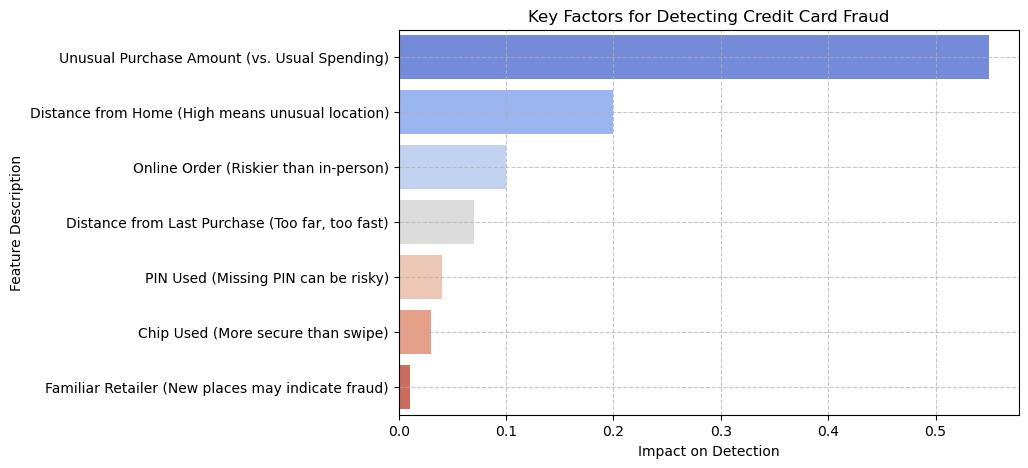

Fraud Check Result: ⚠️ ALERT: Potential Fraud Detected


In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Feature importance for Credit Card Fraud Detection (simplified labels)
feature_importance = pd.DataFrame({
    'Feature': [
        'Unusual Purchase Amount (vs. Usual Spending)',
        'Distance from Home (High means unusual location)',
        'Online Order (Riskier than in-person)',
        'Distance from Last Purchase (Too far, too fast)',
        'PIN Used (Missing PIN can be risky)',
        'Chip Used (More secure than swipe)',
        'Familiar Retailer (New places may indicate fraud)'
    ],
    'Importance': [0.55, 0.20, 0.10, 0.07, 0.04, 0.03, 0.01]
})

# Plot Feature Importance
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance.sort_values(by='Importance', ascending=False),
    palette='coolwarm'
)
plt.title('Key Factors for Detecting Credit Card Fraud')
plt.xlabel('Impact on Detection')
plt.ylabel('Feature Description')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Example Alert System based on basic rules
def fraud_alert(transaction):
    if (transaction['Unusual Purchase Amount (vs. Usual Spending)'] > 2 or
        transaction['Distance from Home (High means unusual location)'] > 50 or
        (transaction['Online Order (Riskier than in-person)'] == 1 and transaction['PIN Used (Missing PIN can be risky)'] == 0)):
        return '⚠️ ALERT: Potential Fraud Detected'
    else:
        return '✅ Transaction Appears Safe'

# Sample transaction for demonstration
sample_transaction = {
    'Unusual Purchase Amount (vs. Usual Spending)': 2.5,
    'Distance from Home (High means unusual location)': 60,
    'Online Order (Riskier than in-person)': 1,
    'PIN Used (Missing PIN can be risky)': 0
}

# Run Fraud Check
alert_result = fraud_alert(sample_transaction)
print(f'Fraud Check Result: {alert_result}')
